# Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

from scipy.fft import fft, fftfreq

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

In [2]:
import random
random.seed(42)

In [3]:
import sys
sys.path.append('..')
sys.path.append('../transforms/')

from transforms.tfc_augmentations import *

In [4]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 22,
    'axes.linewidth': 2,
    'axes.titlesize': 24,
    'axes.edgecolor': 'black',
    'axes.labelsize': 24,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'font.family': 'Times New Roman',
    'legend.fontsize': 16,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

# Overview of The Method


This notebook will detail step-by-step the TF-C pretraining model used in the manuscript *Self-Supervised Contrastive Pre-Training For Time Series via Time-Frequency Consistency*. 


TF-C is a novel pre-training approach for learning generalizable features that can be transferred across different time-series datasets. The following illustration provides an overview of the idea behind and the broad applicability of TF-C. The idea is shown in **(a)**: given a time series sample, time-based and frequency-based embeddings are made close to each other in a latent time-frequency space. The application scenarios are shown in **(b)**: leveraging TF-C in time series, we can generalize a pre-train models to diverse scenarios such as gesture recognition, fault detection, and seizure analysis.


<p align="center">
    <img src="../images/tf_c_fig1.png" width="1000" align="center">
</p>

In a large pre-training time series dataset. TF-C means the time-based representation and the frequency-based representation, which are learned from the same time series sample, are closer to each other in a joint time-frequency space, and farther apart if the representations are associated with different time series samples. By modeling the TF-C, which is a characteristic unique to time series, the developed model can capture the underlying common pattern in time series and further empower knowledge transfer across different time series datasets.

<p align="center">
    <img src="../images/tf_c_fig2.png" width="1000" align="center">
</p>

# Loading the Data

In [5]:
path = '../data/uci/preprocessed/'

df  = pd.read_parquet(path + 'train.parquet')

# 1.1 Augmenting the Time Series 

For a given input time series sample $(x_i)$, we generate an augmentation set $(X^T_i)$ through a time-based augmentation bank $(B_T: x_i \rightarrow X^T_i)$. 

Each element $(\tilde{x}^T_i \in X^T_i)$ is augmented from $(x_i)$ based on the temporal characteristics. Here, the time-based augmentation bank includes well-established methods in contrastive learning

1. jitterin: helps with robustness to small random fluctuations or noise
2. scaling: helps recognize patterns, independently from a scaling factor
3. `time-shifts was not implemented in the github code, but masking!`. Masking was implemented, where we make some parts of the time series equal to 0. Helps with robustness to data gaps
4. neighborhood segments or permutation: robustness to losing temporal ordering or variations in the sequence

In [6]:
def masking(x, keepratio=0.9, mask='binomial'):
    """
    Applies masking to the input data. The selected values are set to zero.
    
    Parameters:
    - x: Input data array (row vector).
    - keepratio: The ratio of values to keep (default is 0.9).
    - mask: The type of mask to use (default is 'binomial').
    
    Returns:
    - Masked data array and affected indices.
    """
    
    x2 = x.copy()
    
    nan_mask = ~np.isnan(x)
    x2[~nan_mask] = 0

    if mask == 'binomial':
        mask_id = np.random.binomial(1, keepratio, size=x.shape).astype(bool)
    else:
        raise ValueError(f"Mask type '{mask}' not supported.")
    
    x2[~mask_id] = 0
    affected_indices = np.where(~mask_id)[0]
    return x2, affected_indices

def jitter(x, sigma=0.8):
    """
    Applies jitter augmentation to the input data.
    
    Parameters:
    - x: Input data.
    - sigma: Standard deviation of the jitter noise (default is 0.8).
    
    Returns:
    - Jittered data.
    """
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=1.1):
    """
    Applies scaling augmentation to the input data. The scaling factor is drawn from a normal distribution and multiplies each value the time series.
    
    Parameters:
    - x: Input data.
    - sigma: Standard deviation of the scaling factor (default is 1.1).
    
    Returns:
    - Scaled data.
    """
    factor = np.random.normal(loc=2., scale=sigma, size=(x.shape))
    return x * factor

def permutation(x, max_segments=5, seg_mode="random"):
    """
    Applies permutation augmentation to the input data. The time series is split into segments and the segments are randomly permuted.
    
    Parameters:
    - x: Input data array (time series).
    - max_segments: Maximum number of segments to split the time series into (default is 5).
    - seg_mode: Mode of segmentation. Can be "random" for random splits or any other value for equal splits (default is "random").
    
    Returns:
    - permuted_data: Permuted time series data.
    - affected_indices: Indices of the original time series that were permuted.
    """
    # Original indices of the time series
    orig_steps = np.arange(x.shape[0])
    
    # Determine the number of segments (at least 1, up to max_segments)
    num_segs = np.random.randint(1, max_segments + 1)
    
    if num_segs > 1:
        if seg_mode == "random":
            # Randomly choose split points
            split_points = np.random.choice(x.shape[0] - 1, num_segs - 1, replace=False)
            split_points.sort()  # Sort split points to maintain order
            splits = np.split(orig_steps, split_points)
        else:
            # Equally split the time series into num_segs segments
            splits = np.array_split(orig_steps, num_segs)
        
        # Permute each segment
        permuted_splits = [np.random.permutation(split) for split in splits]
        
        # Concatenate permuted segments to get the final permuted indices
        warp = np.concatenate(permuted_splits)
        
        # Find affected indices (indices that changed their position)
        affected_indices = np.setdiff1d(orig_steps, warp, assume_unique=True)
        
        # Return permuted data and affected indices
        return x[warp], affected_indices
    else:
        # If num_segs is 1, return the original data without any changes
        return x, []

In [7]:
def compute_normalized_frequency_domain(x, dt):
    """
    Computes the normalized frequency domain representation.
    
    Parameters:
    - x: Input data.
    - dt: Time step.
    
    Returns:
    - Frequency vector and normalized frequency domain representation.
    """
    N = len(x)
    yf = fft(x)
    xf = fftfreq(N, dt)[:N//2]
    return xf, (2.0 / N) * np.abs(yf[:N//2])

def compute_normalized_frequency_domain_hanning(x, dt):
    """
    Computes the normalized frequency domain representation with Hanning window.
    
    Parameters:
    - x: Input data.
    - dt: Time step.
    
    Returns:
    - Frequency vector and normalized frequency domain representation with Hanning window.
    """
    N = len(x)
    windowed_x = x * np.hanning(N)
    yf = fft(windowed_x)
    xf = fftfreq(N, dt)[:N//2]
    return xf, (2.0 / N) * np.abs(yf[:N//2])

def compute_time_vector(length, dt):
    """
    Computes the time vector.
    
    Parameters:
    - length: Length of the time series.
    - dt: Time step.
    
    Returns:
    - Time vector.
    """
    return np.arange(0, length * dt, dt)

In [8]:
sensors = ['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z']

selected_rows = []
for cls in tqdm(np.arange(1,7,1)):
    class_rows = df[df['class'] == cls]
    selected_row = class_rows.sample(n=1, random_state=42)
    selected_rows.append(selected_row)

selected_data = pd.concat(selected_rows)
selected_data

100%|██████████| 6/6 [00:00<00:00, 51.28it/s]


,accel-x_0,accel-x_1,accel-x_2,accel-x_3,accel-x_4,accel-x_5,accel-x_6,accel-x_7,accel-x_8,accel-x_9,...,gyro-z_51,gyro-z_52,gyro-z_53,gyro-z_54,gyro-z_55,gyro-z_56,gyro-z_57,gyro-z_58,gyro-z_59,class
9130,0.137127,0.296700,0.386626,0.356989,0.387329,0.388535,0.315578,0.257519,0.140208,-0.003764,...,0.817465,0.754731,0.642627,0.357229,0.013604,-0.203106,-0.265236,-0.175891,-0.051416,1
1555,-0.204853,-0.192634,-0.221933,-0.225273,-0.241489,-0.270992,-0.279568,-0.292658,-0.280716,-0.254111,...,0.035811,0.007450,-0.015828,-0.005412,0.021018,0.042017,0.045439,0.033574,0.025534,2
9018,0.622364,0.910026,0.991945,0.866384,0.610519,0.348208,0.112806,0.044520,-0.007424,-0.180160,...,-0.006738,-0.210003,-0.352389,-0.341899,-0.159495,0.067625,0.125258,0.068525,0.072359,3
1501,-0.003052,-0.001547,-0.000256,0.001067,0.000781,-0.001158,-0.003406,-0.005516,-0.003666,0.000264,...,0.006211,0.006903,0.007010,0.012951,0.017111,0.007508,-0.000280,0.001619,0.002396,4
6764,-0.000447,-0.001466,-0.001621,-0.000927,0.000151,-0.000165,-0.000883,-0.001777,-0.003184,-0.001316,...,0.007303,0.005547,0.002480,-0.002908,-0.006610,-0.002128,0.001241,0.002546,0.004687,5
2892,0.017627,0.015366,0.012335,0.012249,0.012453,0.012724,0.013683,0.015761,0.019413,0.021963,...,0.003301,-0.000434,-0.001429,-0.002027,-0.001845,0.002415,0.003776,0.002862,0.001106,6


In [9]:
def plot_time_and_frequency_domain(data, classes_to_plot, sensors, operation='jitter', sampling_rate=50, show_hanning=False):
    """
    Plots time and frequency domain representations for specified sensors and classes.
    
    Parameters:
    - data: DataFrame containing the time series data.
    - classes_to_plot: List of classes to plot.
    - sensors: List of sensors to plot.
    - operation: The operation to apply to the data (e.g., 'jitter', 'scaling', 'permutation', 'masking').
    - sampling_rate: Sampling rate of the data in Hz.
    - show_hanning: Boolean to indicate whether to plot Hanning window results (default is True).
    
    Each plot will have two columns: the first column is the time series representation,
    and the second column is the Fourier transform of it (before and after applying the Hanning window).
    """
    
    dt = 1.0 / sampling_rate  # time step

    selected_rows = []
    for cls in classes_to_plot:
        class_rows = data[data['class'] == cls]
        selected_row = class_rows.sample(n=1, random_state=42)
        selected_rows.append(selected_row)

    selected_data = pd.concat(selected_rows)

    fig, axs = plt.subplots(len(selected_data), 2, figsize=(15, 5 * len(selected_data)), constrained_layout=True)

    label_mapping = {
        1: 'WALKING',
        2: 'WALKING_UPSTAIRS',
        3: 'WALKING_DOWNSTAIRS',
        4: 'SITTING',
        5: 'STANDING',
        6: 'LAYING'
    }

    fig.text(0.25, 1.01, 'Time Domain', ha='center', va='center', fontsize=30)
    fig.text(0.75, 1.01, 'Frequency Domain', ha='center', va='center', fontsize=30)

    for i, (_, row) in enumerate(selected_data.iterrows()):
        cls = row['class']
        label = label_mapping.get(cls, f'Class {int(cls)}')
        for j, sensor in enumerate(sensors):
            sensor_columns = [col for col in data.columns if col.startswith(sensor)]
            class_data = row[sensor_columns].values.flatten()
            
            if operation == 'jitter':
                modified_data = jitter(class_data)
                affected_indices = []
            elif operation == 'scaling':
                modified_data = scaling(class_data)
                affected_indices = []
            elif operation == 'permutation':
                modified_data, affected_indices = permutation(class_data)
            elif operation == 'masking':
                modified_data, affected_indices = masking(class_data, keepratio=0.95, mask='binomial')
            else:
                raise ValueError(f"Operation '{operation}' not supported.")
            
            hanning_data = modified_data * np.hanning(len(modified_data))
            
            time_vector = compute_time_vector(len(class_data), dt)
            
            xf_orig, yf_orig = compute_normalized_frequency_domain(class_data, dt)
            xf_mod, yf_mod = compute_normalized_frequency_domain(modified_data, dt)
            xf_hann, yf_hann = compute_normalized_frequency_domain_hanning(modified_data, dt)
            
            axs[i, 0].plot(time_vector, class_data, label='Original')
            axs[i, 0].plot(time_vector, modified_data, label=f'{operation.capitalize()}', linestyle='dashed')
            if show_hanning:
                axs[i, 0].plot(time_vector, hanning_data, label=f'{operation.capitalize()} w/ Hanning', linestyle='dotted')
            axs[i, 0].set_title(f'{label} - {sensor}')
            axs[i, 0].set_xlabel('Time [s]')
            axs[i, 0].set_ylabel('Amplitude')
            axs[i, 0].legend()

            if len(affected_indices) > 0:
                for idx in affected_indices:
                    axs[i, 0].axvspan(time_vector[idx] - dt/2, time_vector[idx] + dt/2, color='red', alpha=0.3)
            
            axs[i, 1].plot(xf_orig, yf_orig, label='Original', alpha=0.5)
            axs[i, 1].plot(xf_mod, yf_mod, label=f'{operation.capitalize()}', linestyle='dashed', alpha=0.5)
            if show_hanning:
                axs[i, 1].plot(xf_hann, yf_hann, label=f'{operation.capitalize()} w/ Hanning', linestyle='dotted', alpha=0.5)
            axs[i, 1].set_title(f'{label} - {sensor}')
            axs[i, 1].set_xlabel('Frequency [Hz]')
            axs[i, 1].set_ylabel('Magnitude')
            axs[i, 1].legend()

    plt.subplots_adjust(top=0.85)
    plt.show()

In [10]:
# plot_time_and_frequency_domain(data = selected_data, 
#                                classes_to_plot=[1,2,3,4,5,6],
#                                sensors = ['accel-y'],
#                                 operation='scaling', # 'jitter', 'scaling', 'permutation', 'masking' 
#                                )

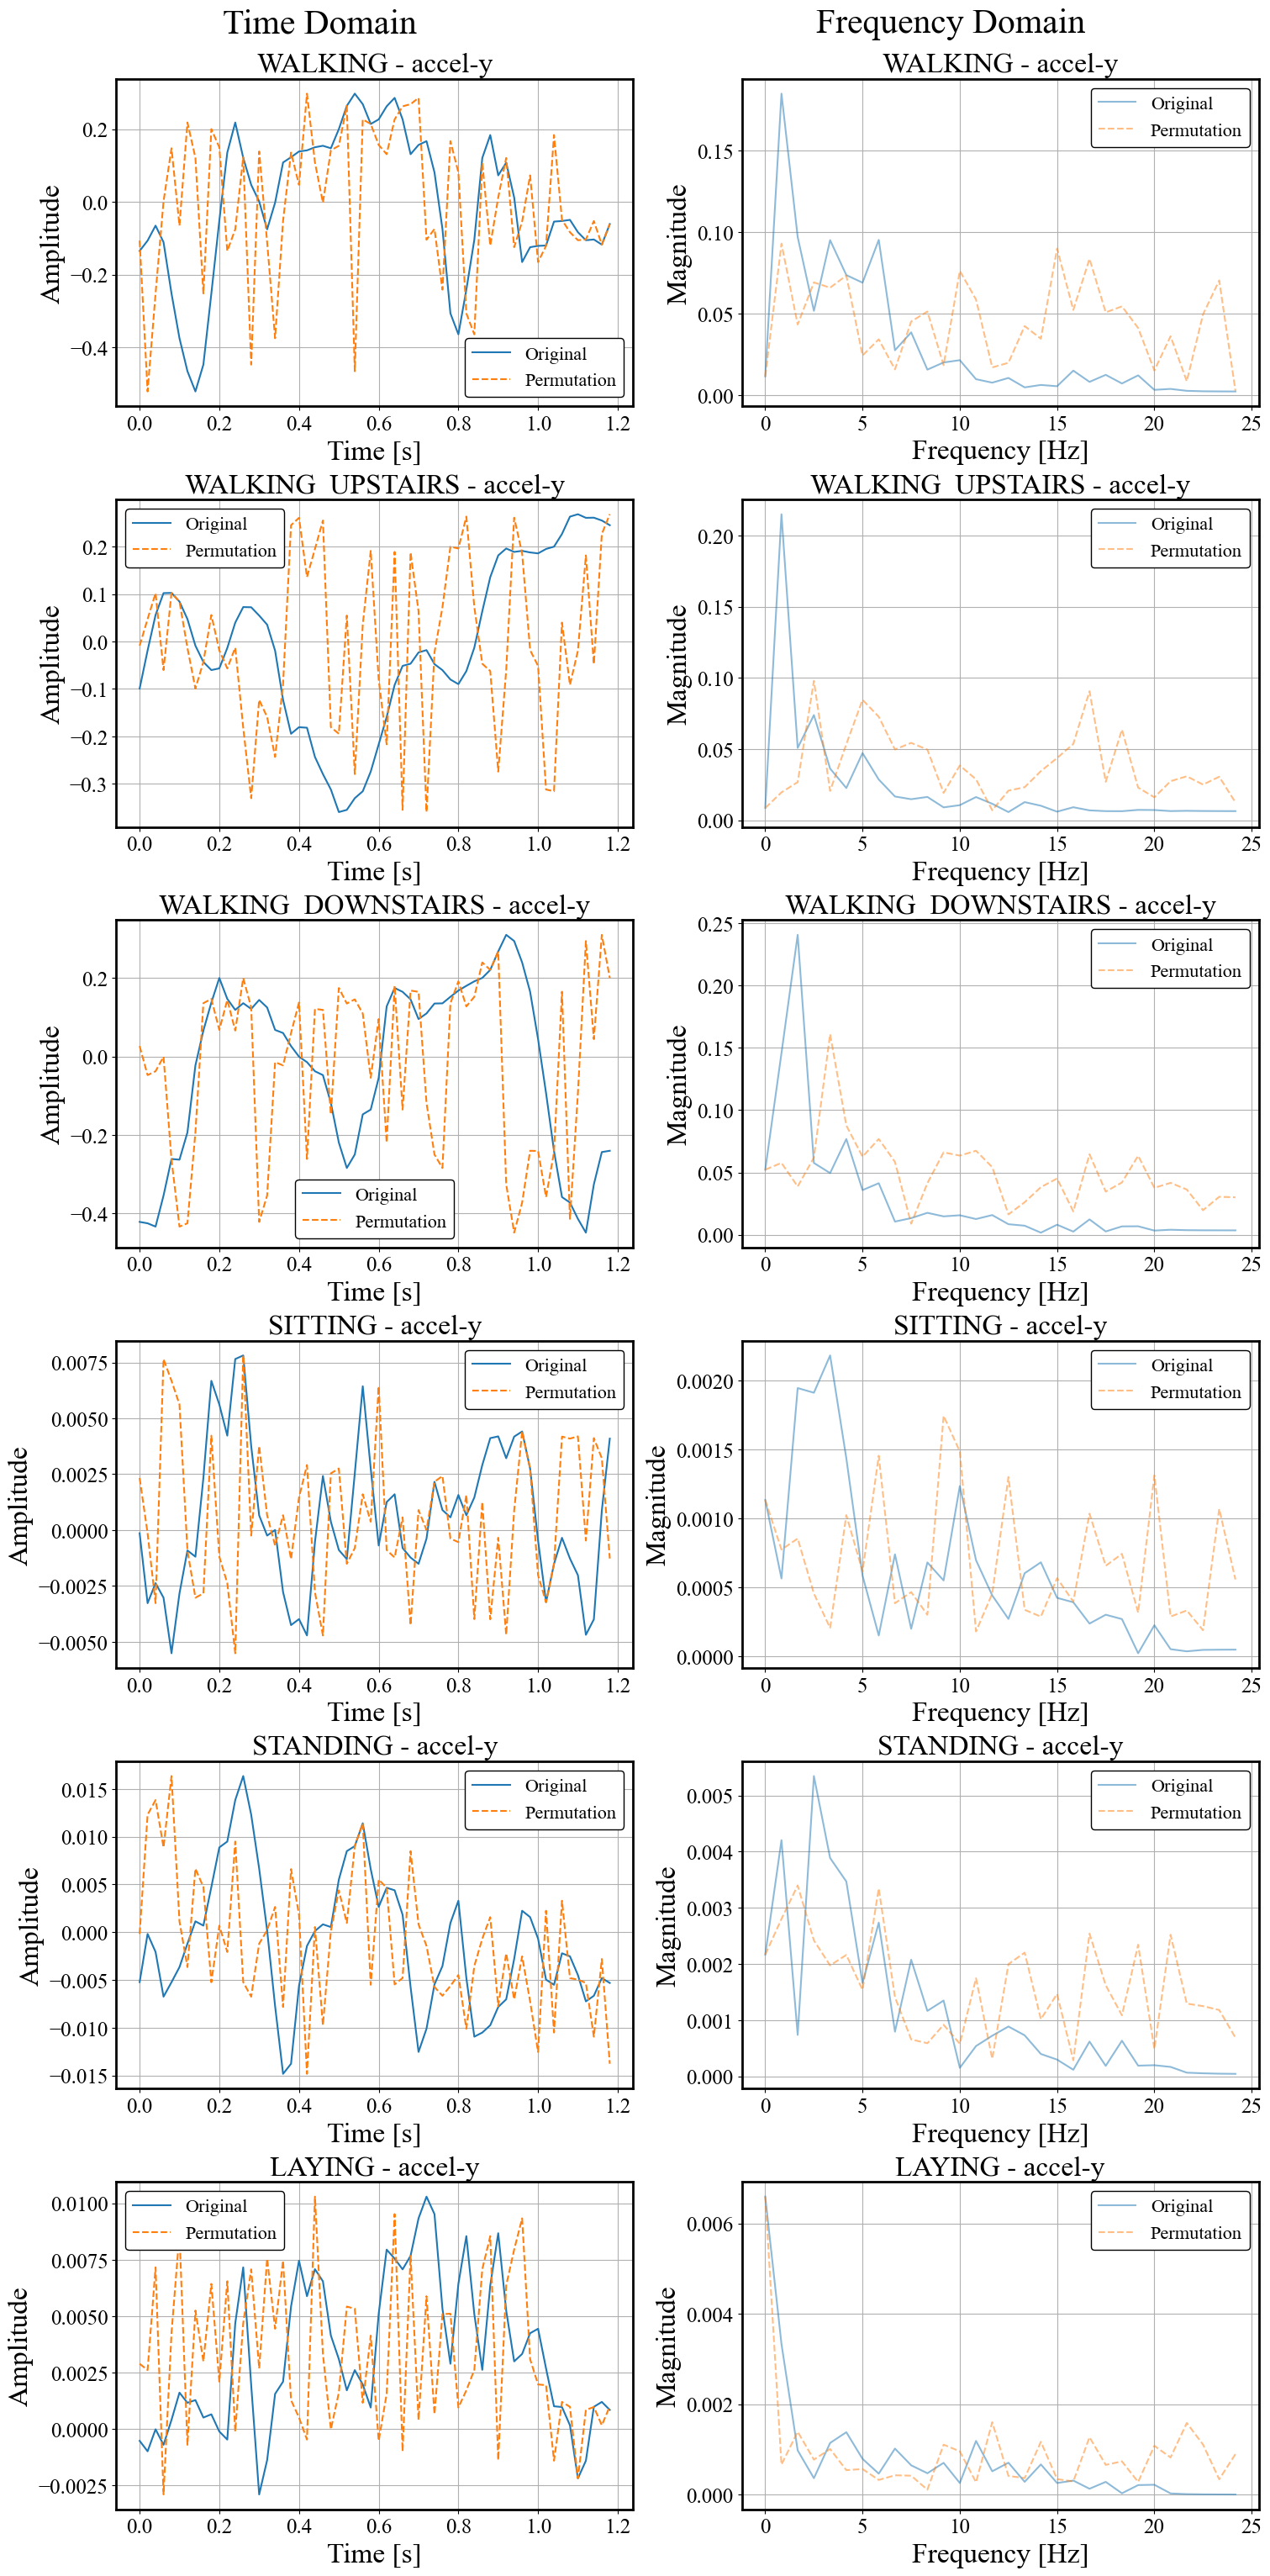

In [11]:
plot_time_and_frequency_domain(data = selected_data, 
                               classes_to_plot=[1,2,3,4,5,6],
                               operation='permutation', # 'jitter', 'scaling', 'permutation', 'masking'
                               sensors = ['accel-y']
                               )

# 1.2 Augmenting the Spectrum

We generate the frequency spectrum $(x^F_i)$ from a time series sample $(x^T_i)$ through a transform operator (e.g., Fourier Transformation). The frequency information in time series is universal and plays a key role in classic signal processing, but it is rarely investigated in self-supervised contrastive representation learning for time series. In this section, we develop an augmentation method to perturb $(x^F_i)$ based on characteristics of frequency spectra and show how to generate frequency-based representations.

As every frequency component in the frequency spectrum denotes a basis function (e.g., sinusoidal function for Fourier transformation) with the corresponding frequency and amplitude, `we perturb the frequency spectrum by adding or removing frequency components`. A small perturbation in the frequency domain may cause large changes to the temporal patterns in the time domain. To make sure the perturbed time series is still similar to the original sample (not only in frequency domain but also in time domain), we use a small budget $(E)$ in the perturbations where $(E)$ denotes the number of frequency components we manipulate. 

While removing frequency components, we randomly select $(E)$ frequency components and set their amplitudes to 0. While adding frequency components, we randomly choose $(E)$ frequency components from the ones that have smaller amplitude than $(\alpha \cdot A_m)$, and increase their amplitude to $(\alpha \cdot A_m)$. The $(A_m)$ is the maximum amplitude in the frequency spectrum and $(\alpha)$ is a pre-defined coefficient to adjust the scale of the perturbed frequency component ($(\alpha = 0.5$) in this work).

**Important points to remember:**

1. Perturbing the low-frequency or high-frequency components depends on the context of where the signal is more informative. For example, EEG is more informative for low frequencies (0.5-70 Hz) while >70 Hz is considered noise. Sensor readings my differ from this context. 

2. DO NOT PERTURB TOO MANY FREQUENCY COMPONENTS. This cause way too many changes in the original time series representation, which makes the contrastive tasks too easy! This leads to bad encoders.

3. No conclusion was drawn from either random sampling or by distribution to select which components to change in the spectrum. Just do random sampling for now

4. The authors did NOT test phase pertubation, only frequency pertubation

Source:

- Appendix J of the TF-C paper

## Implementation

Here we define an augmentation bank where we select one operation as the positive example and all others as a negative example

A configuration file is used to define all hyperparameters used in the study, as seen in the folder config_files

In [ ]:
def DataTransform_TD_bank(sample, config):
    """Augmentation bank that includes four augmentations and randomly select one as the positive sample.
    You may use this one the replace the above DataTransform_TD function."""
    aug_1 = jitter(sample, config.augmentation.jitter_ratio)
    aug_2 = scaling(sample, config.augmentation.jitter_scale_ratio)
    aug_3 = permutation(sample, max_segments=config.augmentation.max_seg)
    aug_4 = masking(sample, keepratio=0.9)

    li = np.random.randint(0, 4, size=[sample.shape[0]])
    li_onehot = one_hot_encoding(li)
    aug_1 = aug_1 * li_onehot[:, 0][:, None, None]  # the rows that are not selected are set as zero.
    aug_2 = aug_2 * li_onehot[:, 0][:, None, None]
    aug_3 = aug_3 * li_onehot[:, 0][:, None, None]
    aug_4 = aug_4 * li_onehot[:, 0][:, None, None]
    aug_T = aug_1 + aug_2 + aug_3 + aug_4
    return aug_T

In [ ]:
def DataTransform_FD(sample, config):
    """Weak and strong augmentations in Frequency domain """
    aug_1 = remove_frequency(sample, pertub_ratio=0.1)
    aug_2 = add_frequency(sample, pertub_ratio=0.1)
    aug_F = aug_1 + aug_2
    return aug_F

# 2. Creating the Time and Frequency Encoders

**Overview of TF-C approach.** The model has four components: a time encoder, a frequency encoder, and two cross-space projectors that map time-based and frequency-based representations, respectively, to the same time-frequency space. Together, the four components provide a way to embed the input time series to the latent time-frequency space such that time-based embedding and frequency-based embedding are close together. 

The TF-C property is realized by promoting the alignment of time- and frequency-based representations in the latent time-frequency space, providing a vehicle for transferring the well-trained model to a target dataset not seen before. Let's see how this is done

## Time encoder


## Frequency encoder

# References:

- https://github.com/mims-harvard/TFC-pretraining/blob/main
- 